In [ ]:
import cv2
import imghdr
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers


In [ ]:
data_path = '/content/drive/MyDrive/skin disease dat/skin-disease-datasaet' # address to the directory of your saved image data.

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png'] # allowed formats

In [ ]:
# code to remove any sort of images in our datasets that are not of our suitable datatypes.
for image_class in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path, image_class)):
        image_path = os.path.join(data_path, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/drive/MyDrive/skin disease dat/skin-disease-datasaet/VI-shingles/IN-rosacea
Issue with image /content/drive/MyDrive/skin disease dat/skin-disease-datasaet/VI-chickenpox/CA-basal-cell-carcinoma


In [ ]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip if it's not a directory

    files = os.listdir(folder_path)

    # Ensure there are files in the folder
    if not files:
        print(f"No files found in folder: {folder_path}")
        continue  # Move to the next iteration

    num_train = int(0.8 * len(files))
    files_train = random.sample(files, num_train)
    files_val = list(set(files) - set(files_train))

    # Load and resize images for training data
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)

        # Check if the image is loaded successfully
        if img is None:
            print(f"Error loading image: {file_path}")
            continue  # Move to the next iteration

        # Check if the image has valid dimensions
        if img.shape[:2] == (0, 0):
            print(f"Empty image: {file_path}")
            continue  # Move to the next iteration

        # Resize the image
        img = cv2.resize(img, (224, 224))
        train_data.append((img, folder))

    # Load and resize images for validation data
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)

        # Check if the image is loaded successfully
        if img is None:
            print(f"Error loading image: {file_path}")
            continue  # Move to the next iteration

        # Check if the image has valid dimensions
        if img.shape[:2] == (0, 0):
            print(f"Empty image: {file_path}")
            continue  # Move to the next iteration

        # Resize the image
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))

Error loading image: /content/drive/MyDrive/skin disease dat/skin-disease-datasaet/VI-shingles/IN-rosacea
Error loading image: /content/drive/MyDrive/skin disease dat/skin-disease-datasaet/VI-chickenpox/CA-basal-cell-carcinoma


In [ ]:
print("training data samples:",len(train_data))
print("validation data samples:",len(val_data))

training data samples: 1416
validation data samples: 361


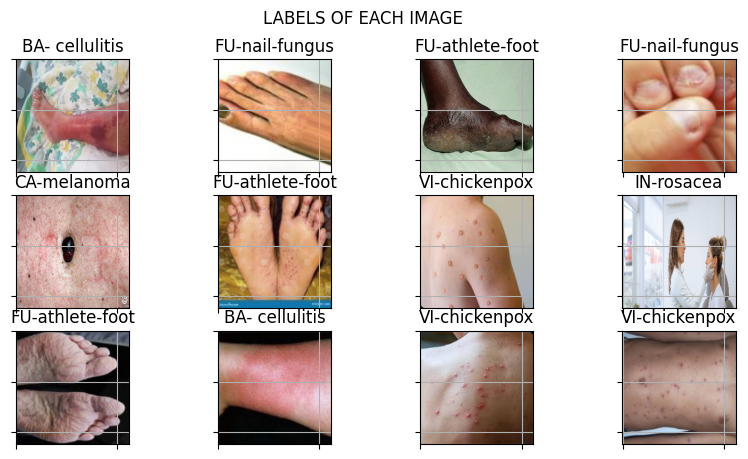

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 12), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [ ]:
labels = ["cellulitis(bacterial)","impetigo(bacterial)","basal-cell-carcinoma(cancer)","melanoma(cancer)","athlete-foot(fungal)","nail-fungas(fungal)","ringworm(fungal)","acne-vulgaris(inflammatory)","rosacea(inflammatory)","cutaneous-larva-migrans(parasitic)","chickenpox(Viral)","shingles(Viral)"]

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
from tensorflow.keras.regularizers import l2
num_classes = 12
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)  # Added dropout layer

predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
logdir='/content/drive/MyDrive/skin disease dat/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
EPOCHS = 6
BATCH_SIZE = 32
hist = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE,callbacks=[tensorboard_callback])

Epoch 1/6
45/45 [==============================] - 18s 197ms/step - loss: 1.3962 - accuracy: 0.5784 - val_loss: 0.7918 - val_accuracy: 0.7452
Epoch 2/6
45/45 [==============================] - 5s 115ms/step - loss: 0.5453 - accuracy: 0.8277 - val_loss: 0.6089 - val_accuracy: 0.8199
Epoch 3/6
45/45 [==============================] - 5s 120ms/step - loss: 0.3432 - accuracy: 0.8997 - val_loss: 0.5787 - val_accuracy: 0.8338
Epoch 4/6
45/45 [==============================] - 5s 121ms/step - loss: 0.2435 - accuracy: 0.9336 - val_loss: 0.5613 - val_accuracy: 0.8421
Epoch 5/6
45/45 [==============================] - 5s 114ms/step - loss: 0.1634 - accuracy: 0.9633 - val_loss: 0.6653 - val_accuracy: 0.8615
Epoch 6/6
45/45 [==============================] - 5s 120ms/step - loss: 0.1302 - accuracy: 0.9732 - val_loss: 0.5725 - val_accuracy: 0.8532


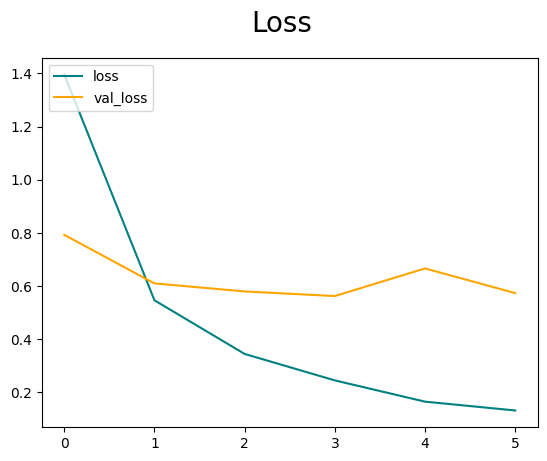

In [ ]:
#plotting losses of training vs cross validation set using tensorboard
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
#reduction in loss of both sets is almost similar hense we can observe no overfitting.


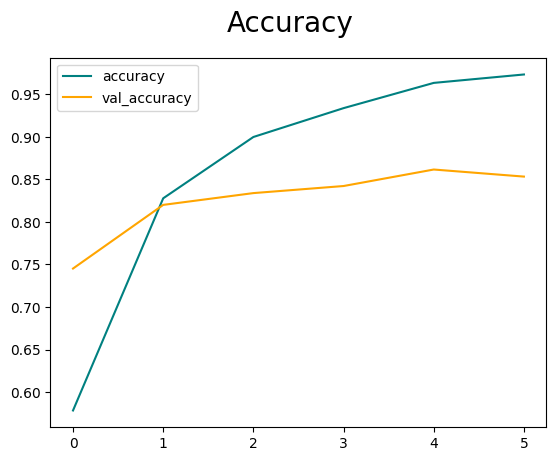

In [ ]:
#plotting accuracy scores of both the sets.
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/skin disease dat/model/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
test_path = '/content/drive/MyDrive/skin disease dat/test_set'

In [ ]:
model = load_model('/content/drive/MyDrive/skin disease dat/model/model.h5')

In [ ]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

In [ ]:
file_path = "/content/drive/MyDrive/skin disease dat/single_test_images/bcc-1.jpeg"
img = cv2.imread(file_path)
img = cv2.resize(img, (224, 224))
img = img / 255.0  # Normalize pixel values between 0 and 1

# Reshape the image to fit the model's expected input shape
img = np.expand_dims(img, axis=0)

# Preprocess the image for ResNet50 model
img = preprocess_input(img)

# Make a prediction
predict_array = model.predict(img)
print(predict_array)

# Use np.argmax to get the class index
'''class_index = np.argmax(predict_array)


label = labels[class_index]

print("The image seems to be:", label)'''

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numeric format
label_encoder = LabelEncoder()
numeric_real_labels = label_encoder.fit_transform(real_label)
numeric_predicted_labels = label_encoder.transform(predicted_class)

# Calculate accuracy
accuracy = accuracy_score(numeric_real_labels, numeric_predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()